In [1]:
import sys
sys.path.insert(1, "../python/architecture")
sys.path.insert(2, "../python/functions")

In [2]:
import numpy as np
from inverse_problem_functions import y_noise
from enkf_functions import enkf_inverse_problem
from plotting_functions import plot_IP_loss_evolution# , plot_IP_loss_evolution_many, plot_IP_true_false, plot_IP_particle_loss, plot_IP_particle_std, plot_IP_iteration_std
from sklearn.metrics import mean_squared_error

In [3]:
def enkf_linear_inverse_problem(setting_dict,
                                analysis_dict
                                ):

    """ Ensemble Kalman Filter algorithm applied to an inverse problem.


    Parameters:

    setting_dict (dict): Dictionary containing
        model_func (function): Function to apply to x.
        x (np.array): True parameters.
        y (np.array): True target variable.
        particles (int): Number of particles in the ensemble.
        iterations (int): Number of iterations.
        noise (bool): Whether or not to add noise to the target variable.
        std (np.array): Standard deviation of the noise.
        h_0 (int or float): Starting step size.
        epsilon (float): Constant for numerical stability in the step size.
        randomization (bool): Whether or not to add noise to the particles and randomize them around their mean.
        loss (str): Which kind of loss to use. Can be either "mse" or "rel_mse"
    analysis_dict (dict): Dictionary containing
        disjoint_batch (bool): Whether or not to use disjoint batches. If False then each batch is sampled with replacement.
        batch_particle_connection (bool): Whether or not to update all particles after each batch even if some particles have not seen that batch.
        tikhonov (dict): Dictionary containing
            regularize (bool): Whether or not to use Tikhonov regularization.
            lambda (None or float): Lambda parameter in Tikhonov regularization.
            reg_mse_stop (bool): Whether or not to stop when MSE + Tikhonov regularization starts to rise again.


    Returns:

    final_params (np.ndarray): Final predicted parameter.
    loss_evolution (list): Evolution of the loss value over each iteration.
    loss_evolution_single_dict (dict): Evolutions of loss values of all particles.

    """

    A = setting_dict["A"]
    x = setting_dict["x"]
    y = setting_dict["y"]
    particles = setting_dict["particles"]
    iterations = setting_dict["iterations"]
    batch_size = setting_dict["batch_size"]
    noise = setting_dict["noise"]
    std = setting_dict["std"]
    h_0 = setting_dict["h_0"]
    epsilon = setting_dict["epsilon"]
    randomization = setting_dict["randomization"]
    loss_type = setting_dict["loss"]
    
    disjoint_batch = analysis_dict["disjoint_batch"]
    batch_particle_connection = analysis_dict["batch_particle_connection"]
    tik_regularize = analysis_dict["tikhonov"]["regularize"]
    tik_lambda = analysis_dict["tikhonov"]["lambda"]
    reg_mse_stop = analysis_dict["tikhonov"]["reg_mse_stop"]
    reg_stop = False
    
    if tik_lambda is None:
        tik_lambda = 0

    if noise and any(std == None):
        raise ValueError("If noise is True, then std can not be None.")
        
    if noise:
        gamma_HM12 = np.sqrt(np.linalg.inv(np.diag(std)))

    def loss(y_true, y_pred, reg):
        if not noise:
            if loss_type == "mse":
                if not tik_regularize:
                    return mean_squared_error(y_true, y_pred)
                else:
                    return mean_squared_error(y_true, y_pred) + tik_lambda * np.sum(reg**2)
            elif loss_type == "rel_mse":
                if not tik_regularize:
                    return mean_squared_error(y_true, y_pred) / np.mean(y_true)
                else:
                    return mean_squared_error(y_true, y_pred) / np.mean(y_true) + tik_lambda * np.sum(reg**2)
        else:
            if loss_type == "mse":
                if not tik_regularize:
                    return np.mean(np.dot(gamma_HM12, y_true - y_pred)**2)
                else:
                    return np.mean(np.dot(gamma_HM12, y_true - y_pred)**2) + tik_lambda * np.sum(reg**2)
            elif loss_type == "rel_mse":
                if not tik_regularize:
                    return np.mean(np.dot(gamma_HM12, y_true - y_pred)**2) / np.mean(y_true)
                else:
                    return np.mean(np.dot(gamma_HM12, y_true - y_pred)**2) / np.mean(y_true) + tik_lambda * np.sum(reg**2)

    def grad_loss(y_true, y_pred):
        if not noise:
            return (-2) / y_true.shape[0] * (y_true - y_pred)
        else:
            return (-2) / y_true.shape[0] * np.diag(gamma_HM12) * (y_true - y_pred)
        
    if batch_size is None:
        batch_size = A.shape[0]
        
    if disjoint_batch:
        n = A.shape[0]
        num_batches = int(np.ceil(n / batch_size))
        batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
        batch_indices[-1] = n
    else:
        n = A.shape[0]
        num_batches = int(np.ceil(n / batch_size))
        last_batch_size = n % batch_size
    
    indices = np.arange(n)
    if disjoint_batch:
        A_batches = [A[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
    else:
        if last_batch_size != 0:
            indices = [np.random.choice(A.shape[0], size = batch_size, replace = True) for i in range(num_batches-1)]
            indices.append(np.random.choice(A.shape[0], size = last_batch_size, replace = True))
        else:
            indices = [np.random.choice(A.shape[0], size = batch_size, replace = True) for i in range(num_batches)]
        A_batches = [A[indices[i]] for i in range(len(indices))]
        y_batches = [y[indices[i]] for i in range(len(indices))]
    
    if batch_particle_connection:
        batch_particle_dict = {}
        batch_particle_indices = np.arange(particles) + 1
        np.random.shuffle(batch_particle_indices)
        if particles == num_batches:
            for i in range(num_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = batch_particle_indices[i]
        elif particles > num_batches:
            base_batches = particles // num_batches
            add_batches = particles % num_batches
            for i in range(num_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = batch_particle_indices[:base_batches]
                batch_particle_indices = batch_particle_indices[base_batches:]
            for i in range(add_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = np.concatenate([batch_particle_dict["batch_{}".format(str(i+1))], np.array([batch_particle_indices[i]])])
        elif num_batches > particles:
            num_reps = int(np.ceil(num_batches / particles))
            particles_repeated = np.tile(batch_particle_indices, num_reps)
            for i in range(num_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = particles_repeated[i]
    else:
        batch_particle_dict = None
                
    param_dict = {}
    y_pred_dict = {}
    jacobian_dict = {}
    loss_dict = {}

    for i in range(particles):
        param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
        y_pred_dict["particle_{}".format(i+1)] = np.dot(A, param_dict["particle_{}".format(i+1)])
        jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
        loss_dict["particle_{}".format(i+1)] = loss(y, y_pred_dict["particle_{}".format(i+1)], param_dict["particle_{}".format(i+1)])

    param_mean = np.mean(list(param_dict.values()), axis = 0)
    final_params = param_mean

    loss_evolution = []
    loss_evolution.append(loss(y, np.dot(A, param_mean), param_dict["particle_{}".format(i+1)]))
    if tik_regularize and reg_mse_stop:
        loss_evolution_reg = []
        loss_evolution_reg.append(loss(y, np.dot(A, param_mean), param_dict["particle_{}".format(i+1)]))

    loss_evolution_single_dict = {}
    for i in range(particles):
        loss_evolution_single_dict["particle_{}".format(i+1)] = [loss(y, np.dot(A, param_dict["particle_{}".format(i+1)]), param_dict["particle_{}".format(i+1)])]

    for iteration in range(iterations):
        if tik_regularize and reg_mse_stop:
            if iteration >= 1:
                if loss_evolution_reg[iteration] > loss_evolution_reg[iteration-1]:
                    reg_stop = True
                    print("Loss containing Tikhonov regularization starts to rise. Algorithm is stopped after epoch (iteration) {}.".format(iteration))
                    break
        for b in range(num_batches):
            batch_particles = []
            y_pred_batch_dict = {}
            jacobian_batch_dict = {}
            # update the predictions, jacobian and loss for the new parameters
            for i in range(particles):
                if batch_particle_connection: 
                    if num_batches == particles or num_batches > particles:
                        if batch_particle_dict["batch_{}".format(str(b+1))] != i+1:
                            continue
                    else:
                        if i+1 not in batch_particle_dict["batch_{}".format(str(b+1))]:
                            continue
                if batch_particle_connection:
                    batch_particles.append(i+1)
                    
                y_pred_dict["particle_{}".format(i+1)] = np.dot(A_batches[b], param_dict["particle_{}".format(i+1)])
                y_pred_batch_dict["particle_{}".format(i+1)] = y_pred_dict["particle_{}".format(i+1)]
                jacobian_dict["particle_{}".format(i+1)] = grad_loss(y_batches[b], y_pred_dict["particle_{}".format(i+1)])
                jacobian_batch_dict["particle_{}".format(i+1)] = jacobian_dict["particle_{}".format(i+1)]
                loss_dict["particle_{}".format(i+1)] = loss(y_batches[b], y_pred_dict["particle_{}".format(i+1)], param_dict["particle_{}".format(i+1)])

            # compute the mean of the predictions
            if batch_particle_connection:
                y_pred_mean = np.mean(list(y_pred_batch_dict.values()), axis = 0)
            else:
                y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)

            # compute the matrix D elementwise
            if not batch_particle_connection:
                d = np.zeros(shape = (particles, particles))
                for k in range(particles):
                    y_pred_centered = y_pred_dict["particle_{}".format(str(k+1))] - y_pred_mean
                    for j in range(particles):
                        d[k][j] = np.dot(y_pred_centered, jacobian_dict["particle_{}".format(str(j+1))])
            else:
                d = np.zeros(shape = (len(y_pred_batch_dict), len(y_pred_batch_dict)))
                for k in range(len(y_pred_batch_dict)):
                    y_pred_centered = list(y_pred_batch_dict.values())[k] - y_pred_mean
                    for j in range(len(y_pred_batch_dict)):
                        d[k][j] = np.dot(y_pred_centered, list(jacobian_batch_dict.values())[j])
            d = np.transpose(d)

            # compute the scalar h_t
            h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)

            # matrix with particle parameters as row vectors
            if not batch_particle_connection:
                params_all_ptcls = np.array(list(param_dict.values()))
            else:
                param_batch_dict = {}
                for i in range(len(batch_particles)):
                    param_batch_dict["particle_{}".format(batch_particles[i])] = param_dict["particle_{}".format(batch_particles[i])]
                    params_all_ptcls = np.array(list(param_batch_dict.values()))

            # compute the matrix with the updates for each particle
            params_all_ptcls = params_all_ptcls - h_t * np.dot(d, params_all_ptcls)

            # write the updates back into the dictionary
            k = -1
            for i in range(particles):
                if batch_particle_connection:
                    if i not in batch_particles:
                        continue
                    k += 1
                    param_dict["particle_{}".format(str(i+1))] = params_all_ptcls[k]
                else:
                    param_dict["particle_{}".format(str(i+1))] = params_all_ptcls[i]

                if randomization:
                    # add randomization/ noise to each particle
                    stddev = 0.1
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = param_dict["particle_{}".format(str(i+1))].shape)
                    new_param = param_dict["particle_{}".format(str(i+1))] + noise
                    param_dict["particle_{}".format(str(i+1))] = new_param

            if randomization:
                # randomize particles around their mean
                param_dict_mean = list(np.mean(list(param_dict.values()), axis = 0))
                for i in range(particles):
                    stddev = 0.1
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = param_dict["particle_{}".format(str(i+1))].shape)
                    new_params = param_dict_mean + noise
                    param_dict["particle_{}".format(str(i+1))] = new_params

        # compute loss for the parameter means
        param_mean = np.mean(params_all_ptcls, axis = 0)
        loss_evolution.append(loss(y, np.dot(A, param_mean), 0))
        if tik_regularize and reg_mse_stop:
            loss_evolution_reg.append(loss(y, np.dot(A, param_mean), param_mean))

        for i in range(particles):
            loss_evolution_single_dict["particle_{}".format(i+1)].append(loss(y, np.dot(A, param_dict["particle_{}".format(i+1)]), 0))
    
    if not reg_stop:
        final_params = param_mean

    return final_params, loss_evolution, loss_evolution_single_dict, batch_particle_dict

# Lineares Modell

## Modell:
$Ax=y$ mit $A$ $m\times n$-Matrix, $m$, $n$ beliebig ($A$ also insbesondere nicht zwingend quadratisch).

$x$ wird gesucht.

In [4]:
A = np.random.uniform(size = (10000, 50))
x = np.random.uniform(size = (A.shape[1], ))

In [5]:
def model_func(x):
    return np.dot(A, x)

In [6]:
noise = False

y, std = y_noise(model_func,
                 x, 
                 noise)

In [7]:
setting_dict = {"A": A,
                "x": x,
                "y": y,
                "particles": 2000,
                "iterations": 10,
                "batch_size" : 200,     # A.shape[0]           
                "noise": noise,
                "std": std,
                "h_0": 2,
                "epsilon": 0.5,
                "randomization": False,
                "loss": "mse"
                }
analysis_dict = {"disjoint_batch": True,
                 "batch_particle_connection": True,
                 "tikhonov": {"regularize": False,
                              "lambda": None,
                              "reg_mse_stop": False}}

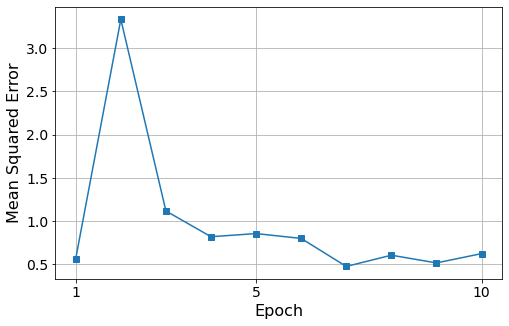

[0.5675297117474873, 3.3314160413935636, 1.117371583196882, 0.8199310611461078, 0.8563133932360731, 0.8001614406836907, 0.47648749698095544, 0.6064043140715936, 0.5171842088873684, 0.6247986618704747]

{'batch_1': array([1910, 1207, 1749, 1784,  222,  239, 1049,  886,  424, 1028,  707,
       1668,  609, 1407, 1304, 1822,  654,  698,  245, 1571,  406, 1507,
        143, 1674, 1839, 1598, 1716,  779, 1070,  382,  703, 1974, 1573,
        173,  996,  426, 1794, 1317, 1031,  407]), 'batch_2': array([ 376,  240,  537, 1917,  463,  937,  994, 1262, 1780, 1641, 1440,
       1574,  718, 1138,   26, 1715, 1630,  821, 1938, 1737, 1454,  309,
        473,  237,  205,  834,  328, 1481,  124, 1025, 1964, 1869,  250,
        547,  387, 1755, 1512,  979,  200, 1445]), 'batch_3': array([  69,  298,  535,  955,  678,  404,   51, 1044, 1163,  433,  385,
       1468, 1419, 1390, 1222, 1759, 1561,  255, 1977,  526,  558,  840,
       1602,   50,  454, 1017,  305,  838, 1181,  674,  434,  477,  741,
     

In [8]:
final_params, loss_evolution, loss_evolution_single_dict, batch_particle_dict = enkf_linear_inverse_problem(setting_dict,
                                                                                                            analysis_dict)
plot_IP_loss_evolution(loss_evolution,
                       start_iteration = 1,
                       xlabel = "Epoch",
                       save = None)
print(loss_evolution[-10:])
print("")
print(batch_particle_dict)

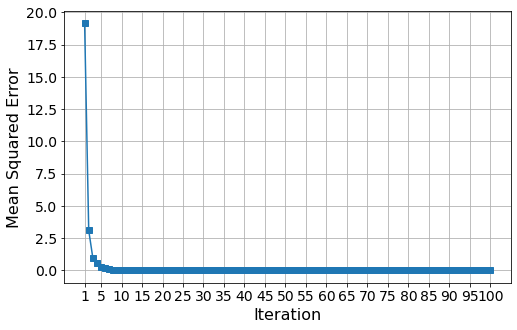

[7.381845024774306e-05,
 7.283810095085156e-05,
 7.188323025885451e-05,
 7.09528631899919e-05,
 7.004607367522152e-05,
 6.916198153894361e-05,
 6.829974969977221e-05,
 6.745858157373481e-05,
 6.663771866277757e-05,
 6.583643831158525e-05]

In [38]:
setting_dict = {"model_func": model_func,
                "x": x,
                "y": y,
                "particles": 200,
                "iterations": 100,
                "noise": noise,
                "std": std,
                "h_0": 2,
                "epsilon": 0.5,
                "randomization": False
                }
final_params, loss_evolution, loss_evolution_single_dict = enkf_inverse_problem(setting_dict)
plot_IP_loss_evolution(loss_evolution,
                       start_iteration = 1,
                       xlabel = "Epoch",
                       save = None)
loss_evolution[-10:]

c:\users\morit\anaconda3\envs\master_thesis\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


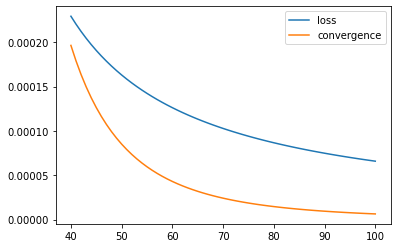

In [59]:
import matplotlib.pyplot as plt

conv = setting_dict["particles"] / np.arange(setting_dict["iterations"]+1)**3.75

plt.plot(np.arange(len(loss_evolution))[40:], loss_evolution[40:], label = "loss")
plt.plot(np.arange(len(loss_evolution))[40:], conv[40:], label = "convergence")
plt.legend()
plt.show()

## Modell:
$Ax=y + \eta$ mit $A$ $m\times n$-Matrix, $m$, $n$ beliebig ($A$ also insbesondere nicht zwingend quadratisch), $\eta\sim\mathscr{N}(0,\Gamma)$.

$x$ wird gesucht.

In [11]:
A = np.random.uniform(size = (10000, 50))
x = np.random.uniform(size = (A.shape[1], ))

In [12]:
def model_func(x):
    return np.dot(A, x)

In [13]:
noise = True

y, std = y_noise(model_func,
                 x, 
                 noise)

In [14]:
setting_dict = {"model_func": model_func,
                "x": x,
                "y": y,
                "particles": 200,
                "iterations": 10,
                "noise": noise,
                "std": std,
                "h_0": 2,
                "epsilon": 0.5,
                "randomization": False
                }

In [15]:
final_params, loss_evolution, loss_evolution_single_dict = enkf_inverse_problem(setting_dict)

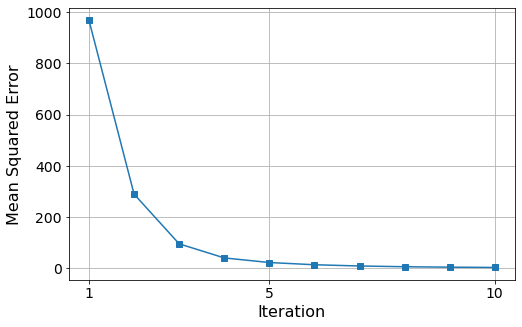

[968.329568644149,
 288.6308761599043,
 94.38224449850807,
 39.319126499133915,
 21.26541185638574,
 12.61735252013598,
 7.739751145073642,
 4.8466280482254795,
 3.1032673980958667,
 2.0470083424443053]

In [17]:
plot_IP_loss_evolution(loss_evolution,
                       start_iteration = 1,
                       xlabel = "Iteration",
                       save = None)
loss_evolution[-10:]